In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Modules & Codes

In [3]:
# Modules
import os

import numpy as np

from tqdm import tqdm
import datetime
from h5py import File as h5File

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

import cv2 as cv

import matplotlib.pyplot as plt

In [4]:
# Parameters
if torch.cuda.is_available():
    DEVICE = 'cuda:0'
else:
    DEVICE = 'cpu'
print(DEVICE)

cpu


In [5]:
# Methods
## Apply OpenCV AffineRotation to a single point
def rotate_xy(M, x, y):
    return np.matmul(
        M,
        np.array([x, y, 1])
    )

# DataLoaders
class AnnotatedDataLoader(Dataset):
    # Constructor
    def __init__(
            self,
            fp_annotated_data,
            factor_augmentations = 1,
            windowsize_min_included = 120,
            crop_size = 400,
            gamma_max_deviation = 0.2,
            always_same_rows = True,
            verbose = False
        ):
        super().__init__()
        self.fp_annotated_data = fp_annotated_data
        self._data_file = h5File(self.fp_annotated_data)
        self.images = self._data_file['data']
        self.nrecords, self.ny, self.nx = self.images.shape
        self.coordinates = self._data_file['annotations']
        self.factor_augmentations = factor_augmentations
        self.n = self.nrecords * self.factor_augmentations
        self.windowsize_min_included = windowsize_min_included
        self.windowsize_min_included2 = self.windowsize_min_included//2
        self.crop_size = crop_size

        self.gamma_max_deviation = gamma_max_deviation
        self.always_same_rows = always_same_rows
        self.verbose = verbose
        return
    # Length
    def __len__(self):
        return self.n
    # Get Item
    def __getitem__(self, i):
        # DEBUG
        if self.always_same_rows:
            np.random.seed(i)
        # Parameters
        idx = i // self.factor_augmentations
        # Choose randomly from 4 possible rotations: 0, 90, 180, 270 degrees
        theta = np.random.choice([ 0, 90, 180, 270 ])
        nx, ny = self.nx, self.ny
        img_processed = self.images[idx]
        y_idx, x_idx = self.coordinates[idx]
        label = 1
        if y_idx >= ny or x_idx >= nx or y_idx < 0 or x_idx < 0:
            label = 0
            y_idx, x_idx = ny//2, nx//2
        # Gamma
        gamma = 1.0 + (np.random.rand()-0.5)*2*self.gamma_max_deviation
        img_processed = ( (img_processed/255)**gamma * 255 ).astype(np.uint8)

        M_rotation = cv.getRotationMatrix2D((nx//2, ny//2), theta, 1.0)
        img_processed = cv.warpAffine(
            img_processed,
            M_rotation,
            (self.nx, self.ny),
            borderValue=255
        )
        coords_new = rotate_xy(M_rotation, x_idx, y_idx).astype(np.int32)

        # Label 0
        if label == 0:
            coords_no_worm = np.array(
                [self.windowsize_min_included2, self.windowsize_min_included2],
                dtype=np.float32
            )
            return img_processed, coords_no_worm, label

        # If Annotation is close to the edge, discard the "Minimum Window Criteria"
        # windowsize_min_included2 = WINDOWSIZE_MIN_INCLUDED2
        # if np.any(coords_new-windowsize_min_included2 < 0) or np.any(coords_new+windowsize_min_included2 >= np.array([nx, ny])):
        #     windowsize_min_included2 = 0
        #     if DEBUG:
        #         print(f"Annotation close to edge encountered! Image IDX: {idx} Label: {label}, Coords: {coords_new}")

        # TODO add passing conditions and handle missing annotation inside the frame
        for _ in range(3):
            # Annotation Outside after Rotation
            if np.any(coords_new >= np.array([nx, ny])) or np.any(coords_new < np.zeros(2)):
                if self.verbose:
                    print("Rotation@annotation outside image: {}-{} , shape:({},{})".format(
                        *coords_new,
                        nx, ny
                    ))
                continue
            if self.verbose:
                print(f"Image IDX: {idx} Label: {label}, COORD NEW: {coords_new}")
            x_idx_new, y_idx_new = coords_new
            # If Conditions
            ## X
            if x_idx_new <= self.windowsize_min_included2:
                x_idx_min, x_idx_max = 0, 0
            elif x_idx_new >= (nx - self.windowsize_min_included2):
                x_idx_min, x_idx_max = nx-self.crop_size, nx-self.crop_size
            elif x_idx_new <= nx//2:
                x_idx_min, x_idx_max = 0, min(x_idx_new - self.windowsize_min_included2, nx-self.crop_size)
            elif x_idx_new > nx//2:
                x_idx_min, x_idx_max = max(0, x_idx_new+self.windowsize_min_included2-self.crop_size), nx-self.crop_size
            else:
                raise NotImplementedError()
            ## Y
            if y_idx_new <= self.windowsize_min_included2:
                y_idx_min, y_idx_max = 0, 0
            elif y_idx_new >= (ny - self.windowsize_min_included2):
                y_idx_min, y_idx_max = ny-self.crop_size, ny-self.crop_size
            elif y_idx_new <= ny//2:
                y_idx_min, y_idx_max = 0, min(y_idx_new - self.windowsize_min_included2, ny-self.crop_size)
            elif y_idx_new > ny//2:
                y_idx_min, y_idx_max = max(0, y_idx_new+self.windowsize_min_included2-self.crop_size), ny-self.crop_size
            else:
                raise NotImplementedError()
            if self.verbose:
                print("IDX X MIN-MAX: {}-{} , Y MIN-MAX: {}-{}".format(
                    x_idx_min, x_idx_max,
                    y_idx_min, y_idx_max
                ))
            # Empty Cropping Area
            if x_idx_max < x_idx_min or y_idx_max < y_idx_min:
                if self.verbose:
                    print("Empty crop area: {}-{} , {}-{}".format(
                        x_idx_min, x_idx_max,
                        y_idx_min, y_idx_max
                    ))
                continue
            if self.verbose:
                print(f"{x_idx_min}-{x_idx_max} , {y_idx_min}-{y_idx_max}")
            crop_topleft = np.random.randint(
                (y_idx_min, x_idx_min),
                (y_idx_max+1,x_idx_max+1)
            )  # so `x` can be used for index `i` in slicing and `y` for column indexing
            if self.verbose:
                print(f"{crop_topleft}")
            # Apply
            imin, jmin = crop_topleft
            imax, jmax = crop_topleft+self.crop_size
            img_processed = img_processed[imin:imax, jmin:jmax]
            coords_new -= crop_topleft[::-1]
            # Return
            if self.verbose:
                print(f"Image IDX: {idx} Label: {label}, COORD NEW Cropped: {coords_new}")
            return img_processed, coords_new, label
        print("DEBUG: Attempts to Augment failed!")
        print(f"Image IDX: {idx} Label: {label}, Coords: {coords_new}")
        raise NotImplementedError()
# DataLoaders
class AnnotatedDataLoaderDebug(Dataset):
    # Constructor
    def __init__(
            self,
            fp_annotated_data,
            factor_augmentations = 1,
            windowsize_min_included = 120,
            crop_size = 400,
            gamma_max_deviation = 0.2,
            always_same_rows = False,
            verbose = False
        ):
        super().__init__()
        self.fp_annotated_data = fp_annotated_data
        self._data_file = h5File(self.fp_annotated_data)
        self.images = self._data_file['data']
        self.nrecords, self.ny, self.nx = self.images.shape
        self.coordinates = self._data_file['annotations']
        self.factor_augmentations = factor_augmentations
        self.n = self.nrecords * self.factor_augmentations
        self.windowsize_min_included = windowsize_min_included
        self.windowsize_min_included2 = self.windowsize_min_included//2
        self.crop_size = crop_size

        self.gamma_max_deviation = gamma_max_deviation
        self.always_same_rows = always_same_rows
        self.verbose = verbose
        return
    # Length
    def __len__(self):
        return self.n
    # Get Item
    def __getitem__(self, i):
        # DEBUG
        if self.always_same_rows:
            np.random.seed(i)
        # Parameters
        idx = i // self.factor_augmentations
        # Choose randomly from 4 possible rotations: 0, 90, 180, 270 degrees
        theta = np.random.choice([ 0, 90, 180, 270 ])
        nx, ny = self.nx, self.ny
        img_processed = self.images[idx]
        y_idx, x_idx = self.coordinates[idx]
        label = 1
        if y_idx >= ny or x_idx >= nx or y_idx < 0 or x_idx < 0:
            label = 0
            y_idx, x_idx = ny//2, nx//2
        # Gamma
        gamma = 1.0 + (np.random.rand()-0.5)*2*self.gamma_max_deviation
        img_processed = ( (img_processed/255)**gamma * 255 ).astype(np.uint8)

        M_rotation = cv.getRotationMatrix2D((nx//2, ny//2), theta, 1.0)
        img_processed = cv.warpAffine(
            img_processed,
            M_rotation,
            (self.nx, self.ny),
            borderValue=255
        )
        coords_new = rotate_xy(M_rotation, x_idx, y_idx).astype(np.int32)

        # Info
        info = np.array([ idx, x_idx, y_idx, label, theta, gamma ], dtype=np.float32)

        # Label 0
        if label == 0:
            coords_no_worm = np.array(
                [self.windowsize_min_included2, self.windowsize_min_included2],
                dtype=np.float32
            )
            return img_processed, coords_no_worm, label, info

        # If Annotation is close to the edge, discard the "Minimum Window Criteria"
        # windowsize_min_included2 = WINDOWSIZE_MIN_INCLUDED2
        # if np.any(coords_new-windowsize_min_included2 < 0) or np.any(coords_new+windowsize_min_included2 >= np.array([nx, ny])):
        #     windowsize_min_included2 = 0
        #     if DEBUG:
        #         print(f"Annotation close to edge encountered! Image IDX: {idx} Label: {label}, Coords: {coords_new}")

        # TODO add passing conditions and handle missing annotation inside the frame
        for _ in range(3):
            # Annotation Outside after Rotation
            if np.any(coords_new >= np.array([nx, ny])) or np.any(coords_new < np.zeros(2)):
                if self.verbose:
                    print("Rotation@annotation outside image: {}-{} , shape:({},{})".format(
                        *coords_new,
                        nx, ny
                    ))
                continue
            if self.verbose:
                print(f"Image IDX: {idx} Label: {label}, COORD NEW: {coords_new}")
            x_idx_new, y_idx_new = coords_new
            # If Conditions
            ## X
            if x_idx_new <= self.windowsize_min_included2:
                x_idx_min, x_idx_max = 0, 0
            elif x_idx_new >= (nx - self.windowsize_min_included2):
                x_idx_min, x_idx_max = nx-self.crop_size, nx-self.crop_size
            elif x_idx_new <= nx//2:
                x_idx_min, x_idx_max = 0, min(x_idx_new - self.windowsize_min_included2, nx-self.crop_size)
            elif x_idx_new > nx//2:
                x_idx_min, x_idx_max = max(0, x_idx_new+self.windowsize_min_included2-self.crop_size), nx-self.crop_size
            else:
                raise NotImplementedError()
            ## Y
            if y_idx_new <= self.windowsize_min_included2:
                y_idx_min, y_idx_max = 0, 0
            elif y_idx_new >= (ny - self.windowsize_min_included2):
                y_idx_min, y_idx_max = ny-self.crop_size, ny-self.crop_size
            elif y_idx_new <= ny//2:
                y_idx_min, y_idx_max = 0, min(y_idx_new - self.windowsize_min_included2, ny-self.crop_size)
            elif y_idx_new > ny//2:
                y_idx_min, y_idx_max = max(0, y_idx_new+self.windowsize_min_included2-self.crop_size), ny-self.crop_size
            else:
                raise NotImplementedError()
            if self.verbose:
                print("IDX X MIN-MAX: {}-{} , Y MIN-MAX: {}-{}".format(
                    x_idx_min, x_idx_max,
                    y_idx_min, y_idx_max
                ))
            # Empty Cropping Area
            if x_idx_max < x_idx_min or y_idx_max < y_idx_min:
                if self.verbose:
                    print("Empty crop area: {}-{} , {}-{}".format(
                        x_idx_min, x_idx_max,
                        y_idx_min, y_idx_max
                    ))
                continue
            if self.verbose:
                print(f"{x_idx_min}-{x_idx_max} , {y_idx_min}-{y_idx_max}")
            crop_topleft = np.random.randint(
                (y_idx_min, x_idx_min),
                (y_idx_max+1,x_idx_max+1)
            )  # so `x` can be used for index `i` in slicing and `y` for column indexing
            if self.verbose:
                print(f"{crop_topleft}")
            # Apply
            imin, jmin = crop_topleft
            imax, jmax = crop_topleft+self.crop_size
            img_processed = img_processed[imin:imax, jmin:jmax]
            coords_new -= crop_topleft[::-1]
            # Return
            if self.verbose:
                print(f"Image IDX: {idx} Label: {label}, COORD NEW Cropped: {coords_new}")
            return img_processed, coords_new, label, info
        print("DEBUG: Attempts to Augment failed!")
        print(f"Image IDX: {idx} Label: {label}, Coords: {coords_new}")
        raise NotImplementedError()

# Collator Functions
def collate_fn_3d_input(data):
    images, coords, _  = zip(*data)
    coords = np.array(coords)
    images = np.repeat(
        np.array(images)[:,None,:,:], 3, axis=1
    )
    images_channeled = torch.tensor( images, dtype=torch.float32 )
    coords = torch.tensor( coords, dtype=torch.float32 )
    return images_channeled, coords

# Collator Functions
def collate_fn_3d_input_debug(data):
    images, coords, _, infos = zip(*data)
    coords = np.array(coords)
    images = np.repeat(
        np.array(images)[:,None,:,:], 3, axis=1
    )
    images_channeled = torch.tensor( images, dtype=torch.float32 )
    coords = torch.tensor( coords, dtype=torch.float32 )
    infos = torch.tensor( np.array(infos), dtype=torch.float32 )
    return images_channeled, coords, infos

In [6]:
# Trainers
## Coordinates Trainer
class TrainerCoordinates:
    # Constructor
    def __init__(
            self,
            model,
            data_loader_train,
            data_loader_validation = None,
            optimizer_name = 'adam',
            optimizer_lr = 1e-3,
            device = 'auto',
            fp_checkpoints = None
        ) -> None:
        self.model = model
        self.data_loader_train = data_loader_train
        self.data_loader_validation = data_loader_validation if data_loader_validation is not None else self.data_loader_train
        self.loss_fn = torch.nn.MSELoss()
        self.optimizer_name = optimizer_name.lower()
        self.optimizer_lr = optimizer_lr
        if self.optimizer_name == 'adam':
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.optimizer_lr)
        else:
            raise NotImplementedError()
        self.device = device
        if device == 'auto':
            if torch.cuda.is_available():
                self.device = 'cuda:0'
            else:
                self.device = 'cpu'
        # Base Path
        assert fp_checkpoints is not None, 'Checkpoints path should be provided.'
        _date_key = str(datetime.datetime.now())[:19].replace(':','').replace(' ','_')
        self.fp_checkpoints = os.path.join(
            fp_checkpoints,
            _date_key
        )
        return
    # Train
    def train(self, n_epochs, n_epochs_checkpoint = 10):
        model = self.model.to(self.device)
        loss_fn = self.loss_fn
        logs = []
        for i_epoch in range(n_epochs):
            print(f"### Epoch: {i_epoch+1:>3}/{n_epochs:<3}")
            losses_epoch_train = []

            # Train
            steps = tqdm(self.data_loader_train, desc=f'Epoch Steps - Train Loss: {0.0:>7.3f}')
            model.train()
            for x_train, y_train in steps:
                x_train = x_train.to(self.device)
                y_train = y_train.to(self.device)
                # Zero your gradients for every batch!
                self.optimizer.zero_grad()

                # Make predictions for this batch
                y_train_pred = model(x_train)

                # Compute the loss and its gradients
                loss = loss_fn(y_train_pred, y_train)
                loss.backward()
                loss_value = loss.cpu().item()

                # Adjust learning weights
                self.optimizer.step()

                # Log
                losses_epoch_train.append(loss_value)
                steps.set_description(
                    'Epoch Steps - Train Loss: {:>7.3f}'.format(loss_value)
                )
            # Validation
            losses_epoch_validation = []
            model.eval()
            with torch.no_grad():
                steps = tqdm(self.data_loader_validation, desc=f'Epoch Steps - Validation Loss: {0.0:>7.3f}')
                for x_train, y_train in steps:
                    x_train = x_train.to(self.device)
                    y_train = y_train.to(self.device)
                    # Make predictions for this batch
                    y_train_pred = model(x_train)

                    # Compute the loss and its gradients
                    loss = loss_fn(y_train_pred, y_train)
                    loss_value = loss.cpu().item()

                    # Log
                    losses_epoch_validation.append(loss_value)
                    steps.set_description(
                        'Epoch Steps - Validation Loss: {:>7.3f}'.format(loss_value)
                    )
            logs.append([
                np.mean(losses_epoch_train), np.mean(losses_epoch_validation),
                losses_epoch_train, losses_epoch_validation
            ])
            # Save Model
            if (i_epoch+1)%n_epochs_checkpoint == 0:
                if not os.path.exists(self.fp_checkpoints):
                    os.mkdir(self.fp_checkpoints)
                fp_model = os.path.join( self.fp_checkpoints, str(i_epoch).zfill(3)+".pt" )
                torch.save({
                    'epoch': i_epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'loss_train': np.mean(losses_epoch_train),
                    'loss_validation': np.mean(losses_epoch_validation),
                    },
                    fp_model
                )
        return logs
    # Test
    def test(self, data_loader_test):
        model = self.model.to(self.device)
        loss_fn = self.loss_fn

        # Test
        losses_epoch_test = []
        model.eval()
        with torch.no_grad():
            steps = tqdm(data_loader_test, desc=f'Epoch Steps - Test Loss: {0.0:>7.3f}')
            for x_train, y_train in steps:
                x_train = x_train.to(self.device)
                y_train = y_train.to(self.device)
                # Make predictions for this batch
                y_train_pred = model(x_train)

                # Compute the loss and its gradients
                loss = loss_fn(y_train_pred, y_train)
                loss_value = loss.cpu().item()

                # Log
                losses_epoch_test.append(loss_value)
                steps.set_description(
                    'Epoch Steps - Test Loss: {:>7.3f}'.format(loss_value)
                )
        return losses_epoch_test


In [ ]:
from torchvision import models
#################################################################
model = models.resnet18(pretrained=True) # weights='IMAGENET1K_V1',
num_ftrs = model.fc.in_features
# Freeze All Other Layers except last
# for param in model.parameters():
#     param.requires_grad = False
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(DEVICE)
#################################################################
# model = models.resnet18(pretrained=False) # weights='IMAGENET1K_V1',
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 2)
# model = model.to(DEVICE)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 263MB/s]


In [10]:
fp_base = "/content/drive/MyDrive/NortheasternUniversity/VenkatachalamLab/20230623TrackingNN"

# Split Train, Validation and Test

In [ ]:
file_training_data = h5File(
    f"{fp_base}/training_data.h5"
)
list(file_training_data)

['annotations', 'data', 'index']

In [ ]:
# Select Test Subset
indices = file_training_data['index'][:,0]
indices_test = np.array([
    i in {7,9,12} for i in indices
])
indices_train = ~indices_test


# Select Validation Subset
indices_train_validation = np.array([
    i in {2,4} for i in indices
])


indices_train_train = (~indices_test) & (~indices_train_validation)

In [ ]:
np.sum(indices_test), np.sum(indices_train_train), np.sum(indices_train_validation)

(516, 1754, 470)

In [ ]:
# Test
with h5File("data_test.h5", 'w') as out_file:
    indices = np.where(indices_test)[0]
    out_file['data'] = file_training_data['data'][indices]
    out_file['annotations'] = file_training_data['annotations'][indices]
    out_file['index'] = file_training_data['index'][indices]
# Train-Train
with h5File("data_train_train.h5", 'w') as out_file:
    indices = np.where(indices_train_train)[0]
    out_file['data'] = file_training_data['data'][indices]
    out_file['annotations'] = file_training_data['annotations'][indices]
    out_file['index'] = file_training_data['index'][indices]
# Train-Validation
with h5File("data_train_validation.h5", 'w') as out_file:
    indices = np.where(indices_train_validation)[0]
    out_file['data'] = file_training_data['data'][indices]
    out_file['annotations'] = file_training_data['annotations'][indices]
    out_file['index'] = file_training_data['index'][indices]

In [ ]:
file_training_data.close()



---



# Training Part
For evaluation using a checkpoint, scroll down

In [ ]:
dataloader_test = DataLoader(
    AnnotatedDataLoader(
        fp_annotated_data="data_test.h5",
        factor_augmentations=4,
        always_same_rows=False
    ),
    batch_size=32, shuffle=True,
    collate_fn=collate_fn_3d_input
)

dataloader_train_train = DataLoader(
    AnnotatedDataLoader(
        fp_annotated_data="data_train_train.h5",
        factor_augmentations=5,
        always_same_rows=False
    ),
    batch_size=32, shuffle=True,
    collate_fn=collate_fn_3d_input
)

dataloader_train_validation = DataLoader(
    AnnotatedDataLoader(
        fp_annotated_data="data_train_validation.h5",
        factor_augmentations=5,
        always_same_rows=False
    ),
    batch_size=32, shuffle=True,
    collate_fn=collate_fn_3d_input
)

In [ ]:
# Training
fp_models = os.path.join( f"{fp_base}/models" )

In [ ]:
trainer = TrainerCoordinates(
    model,
    data_loader_train=dataloader_train_train,
    data_loader_validation=dataloader_train_validation,
    fp_checkpoints=fp_models
)

In [ ]:
logs_train = trainer.train(50)

### Epoch:   1/50 


Epoch Steps - Validation Loss: 4444.330: 100%|██████████| 74/74 [00:32<00:00,  2.27it/s]


### Epoch:   2/50 


Epoch Steps - Validation Loss: 1215.975: 100%|██████████| 74/74 [00:30<00:00,  2.40it/s]


### Epoch:   3/50 


Epoch Steps - Validation Loss: 836.625: 100%|██████████| 74/74 [00:30<00:00,  2.41it/s]


### Epoch:   4/50 


Epoch Steps - Validation Loss: 1086.706: 100%|██████████| 74/74 [00:31<00:00,  2.31it/s]


### Epoch:   5/50 


Epoch Steps - Validation Loss: 1235.717: 100%|██████████| 74/74 [00:31<00:00,  2.35it/s]


### Epoch:   6/50 


Epoch Steps - Validation Loss: 1576.114: 100%|██████████| 74/74 [00:32<00:00,  2.31it/s]


### Epoch:   7/50 


Epoch Steps - Validation Loss: 552.988: 100%|██████████| 74/74 [00:30<00:00,  2.41it/s]


### Epoch:   8/50 


Epoch Steps - Validation Loss: 932.538: 100%|██████████| 74/74 [00:32<00:00,  2.29it/s]


### Epoch:   9/50 


Epoch Steps - Validation Loss: 519.979: 100%|██████████| 74/74 [00:30<00:00,  2.41it/s]


### Epoch:  10/50 


Epoch Steps - Validation Loss: 1261.820: 100%|██████████| 74/74 [00:30<00:00,  2.40it/s]


### Epoch:  11/50 


Epoch Steps - Validation Loss:  81.805: 100%|██████████| 74/74 [00:30<00:00,  2.42it/s]


### Epoch:  12/50 


Epoch Steps - Validation Loss: 1853.383: 100%|██████████| 74/74 [00:31<00:00,  2.31it/s]


### Epoch:  13/50 


Epoch Steps - Validation Loss: 331.690: 100%|██████████| 74/74 [00:30<00:00,  2.41it/s]


### Epoch:  14/50 


Epoch Steps - Validation Loss: 1184.104: 100%|██████████| 74/74 [00:30<00:00,  2.39it/s]


### Epoch:  15/50 


Epoch Steps - Validation Loss: 898.040: 100%|██████████| 74/74 [00:31<00:00,  2.33it/s]


### Epoch:  16/50 


Epoch Steps - Validation Loss: 325.424: 100%|██████████| 74/74 [00:32<00:00,  2.30it/s]


### Epoch:  17/50 


Epoch Steps - Validation Loss: 118.362: 100%|██████████| 74/74 [00:30<00:00,  2.42it/s]


### Epoch:  18/50 


Epoch Steps - Validation Loss: 550.701: 100%|██████████| 74/74 [00:30<00:00,  2.40it/s]


### Epoch:  19/50 


Epoch Steps - Validation Loss: 165.407: 100%|██████████| 74/74 [00:31<00:00,  2.34it/s]


### Epoch:  20/50 


Epoch Steps - Validation Loss: 332.442: 100%|██████████| 74/74 [00:30<00:00,  2.40it/s]


### Epoch:  21/50 


Epoch Steps - Validation Loss: 607.321: 100%|██████████| 74/74 [00:30<00:00,  2.43it/s]


### Epoch:  22/50 


Epoch Steps - Validation Loss: 779.566: 100%|██████████| 74/74 [00:31<00:00,  2.38it/s]


### Epoch:  23/50 


Epoch Steps - Validation Loss:  72.253: 100%|██████████| 74/74 [00:30<00:00,  2.41it/s]


### Epoch:  24/50 


Epoch Steps - Validation Loss: 268.246: 100%|██████████| 74/74 [00:30<00:00,  2.41it/s]


### Epoch:  25/50 


Epoch Steps - Validation Loss: 454.381: 100%|██████████| 74/74 [00:31<00:00,  2.32it/s]


### Epoch:  26/50 


Epoch Steps - Validation Loss: 1170.747: 100%|██████████| 74/74 [00:31<00:00,  2.36it/s]


### Epoch:  27/50 


Epoch Steps - Validation Loss: 296.222: 100%|██████████| 74/74 [00:31<00:00,  2.38it/s]


### Epoch:  28/50 


Epoch Steps - Validation Loss: 349.965: 100%|██████████| 74/74 [00:30<00:00,  2.41it/s]


### Epoch:  29/50 


Epoch Steps - Validation Loss:  38.803: 100%|██████████| 74/74 [00:31<00:00,  2.39it/s]


### Epoch:  30/50 


Epoch Steps - Validation Loss: 1319.395: 100%|██████████| 74/74 [00:30<00:00,  2.43it/s]


### Epoch:  31/50 


Epoch Steps - Validation Loss: 239.383: 100%|██████████| 74/74 [00:31<00:00,  2.35it/s]


### Epoch:  32/50 


Epoch Steps - Validation Loss: 623.322: 100%|██████████| 74/74 [00:30<00:00,  2.41it/s]


### Epoch:  33/50 


Epoch Steps - Validation Loss:  59.771: 100%|██████████| 74/74 [00:31<00:00,  2.35it/s]


### Epoch:  34/50 


Epoch Steps - Validation Loss: 200.326: 100%|██████████| 74/74 [00:32<00:00,  2.27it/s]


### Epoch:  35/50 


Epoch Steps - Validation Loss: 2224.010: 100%|██████████| 74/74 [00:31<00:00,  2.36it/s]


### Epoch:  36/50 


Epoch Steps - Validation Loss: 621.298: 100%|██████████| 74/74 [00:31<00:00,  2.37it/s]


### Epoch:  37/50 


Epoch Steps - Validation Loss: 420.218: 100%|██████████| 74/74 [00:30<00:00,  2.39it/s]


### Epoch:  38/50 


Epoch Steps - Validation Loss:  70.700: 100%|██████████| 74/74 [00:30<00:00,  2.40it/s]


### Epoch:  39/50 


Epoch Steps - Validation Loss: 634.119: 100%|██████████| 74/74 [00:31<00:00,  2.33it/s]


### Epoch:  40/50 


Epoch Steps - Validation Loss: 397.223: 100%|██████████| 74/74 [00:30<00:00,  2.41it/s]


### Epoch:  41/50 


Epoch Steps - Validation Loss:  49.920: 100%|██████████| 74/74 [00:31<00:00,  2.34it/s]


### Epoch:  42/50 


Epoch Steps - Validation Loss: 153.816: 100%|██████████| 74/74 [00:30<00:00,  2.42it/s]


### Epoch:  43/50 


Epoch Steps - Validation Loss:  16.261: 100%|██████████| 74/74 [00:30<00:00,  2.39it/s]


### Epoch:  44/50 


Epoch Steps - Validation Loss:  29.573: 100%|██████████| 74/74 [00:31<00:00,  2.33it/s]


### Epoch:  45/50 


Epoch Steps - Validation Loss: 404.293: 100%|██████████| 74/74 [00:30<00:00,  2.41it/s]


### Epoch:  46/50 


Epoch Steps - Validation Loss: 201.526: 100%|██████████| 74/74 [00:31<00:00,  2.32it/s]


### Epoch:  47/50 


Epoch Steps - Validation Loss: 485.029: 100%|██████████| 74/74 [00:32<00:00,  2.29it/s]


### Epoch:  48/50 


Epoch Steps - Train Loss: 139.507:   7%|▋         | 20/275 [00:12<02:31,  1.68it/s]

In [ ]:
logs_test = trainer.test(dataloader_test)

# Get Predictions with Extra Informations

In [ ]:
dataloader_train_train_training = DataLoader(
    AnnotatedDataLoader(
        fp_annotated_data="data_train_train.h5",
        factor_augmentations=5,
        always_same_rows=False
    ),
    batch_size=128, shuffle=True,
    collate_fn=collate_fn_3d_input
)


dataloader_test = DataLoader(
    AnnotatedDataLoaderDebug(
        fp_annotated_data="data_test.h5",
        factor_augmentations=4,
        always_same_rows=False
    ),
    batch_size=128, shuffle=True,
    collate_fn=collate_fn_3d_input_debug
)

dataloader_train_train = DataLoader(
    AnnotatedDataLoaderDebug(
        fp_annotated_data="data_train_train.h5",
        factor_augmentations=5,
        always_same_rows=False
    ),
    batch_size=128, shuffle=True,
    collate_fn=collate_fn_3d_input_debug
)

dataloader_train_validation = DataLoader(
    AnnotatedDataLoaderDebug(
        fp_annotated_data="data_train_validation.h5",
        factor_augmentations=5,
        always_same_rows=False
    ),
    batch_size=128, shuffle=True,
    collate_fn=collate_fn_3d_input_debug
)

In [ ]:
fp_checkpoint = f"{fp_base}/models/2023-06-27_222549/039.pt"
checkpoint = torch.load(fp_checkpoint, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
loss_train = checkpoint['loss_train']
loss_validation = checkpoint['loss_validation']
_ = model.eval()

In [ ]:
import gc
loss_fn = nn.MSELoss()

# Train-Train
with torch.no_grad():
    steps = tqdm(dataloader_train_train, desc=f'Epoch Steps - Train-Train Loss: {0.0:>7.3f}')
    for i_batch, (x, y, infos) in enumerate(steps):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss_value = loss.cpu().item()

        # Log
        steps.set_description(
            'Epoch Steps - Train-Train Loss: {:>7.3f}'.format(loss_value)
        )

        # Store
        fp_result = "{}/models/2023-06-27_222549/evaluations/train_train_{}.npz".format(
            fp_base,
            str(i_batch).zfill(3)
        )
        np.savez_compressed(
            fp_result,
            x = x[:,0,:,:].numpy(),
            y = y.numpy(),
            y_pred = y_pred.numpy(),
            infos = infos.numpy()
        )
        gc.collect()

Epoch Steps - Train-Train Loss:  41.601: 100%|██████████| 69/69 [59:45<00:00, 51.97s/it]


In [ ]:
# Train-Validation
with torch.no_grad():
    steps = tqdm(dataloader_train_validation, desc=f'Epoch Steps - Train-Validation Loss: {0.0:>7.3f}')
    for i_batch, (x, y, infos) in enumerate(steps):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss_value = loss.cpu().item()

        # Log
        steps.set_description(
            'Epoch Steps - Train-Validation Loss: {:>7.3f}'.format(loss_value)
        )

        # Store
        fp_result = "{}/models/2023-06-27_222549/evaluations/train_validation_{}.npz".format(
            fp_base,
            str(i_batch).zfill(3)
        )
        np.savez_compressed(
            fp_result,
            x = x[:,0,:,:].numpy(),
            y = y.numpy(),
            y_pred = y_pred.numpy(),
            infos = infos.numpy()
        )
        gc.collect()
# Test
with torch.no_grad():
    steps = tqdm(dataloader_test, desc=f'Epoch Steps - Test Loss: {0.0:>7.3f}')
    for i_batch, (x, y, infos) in enumerate(steps):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss_value = loss.cpu().item()

        # Log
        steps.set_description(
            'Epoch Steps - Test Loss: {:>7.3f}'.format(loss_value)
        )

        # Store
        fp_result = "{}/models/2023-06-27_222549/evaluations/test_{}.npz".format(
            fp_base,
            str(i_batch).zfill(3)
        )
        np.savez_compressed(
            fp_result,
            x = x[:,0,:,:].numpy(),
            y = y.numpy(),
            y_pred = y_pred.numpy(),
            infos = infos.numpy()
        )
        gc.collect()

Epoch Steps - Test Loss: 1044.051: 100%|██████████| 17/17 [13:52<00:00, 48.97s/it]


# Evaluate in Details
- use the dataloaders with collator functions for debug
- report both for training, validation and test, good and bad results
- check result performance by index of dataset
- check result performance by checkpoint number

In [29]:
from glob import glob
import gc

In [11]:
fp_base = "/content/drive/MyDrive/NortheasternUniversity/VenkatachalamLab/20230623TrackingNN"
fp_checkpoint_folder = f"{fp_base}/models/2023-06-27_222549"

In [30]:
train_train = {
    'xs': [],
    'ys': [],
    'ys_pred': [],
    'image_idxs': [],
    'labels': [],
    'thetas': [],
    'gammas': [],
}
for fp in tqdm( glob(fp_checkpoint_folder+"/evaluations/train_train_*.npz") ):
    with np.load(fp) as in_file:
        train_train['xs'].extend( in_file['x'] )
        train_train['ys'].extend( in_file['y'] )
        train_train['ys_pred'].extend( in_file['y_pred'] )
        infos = in_file['infos'] # 0: image_idx, 1: x_idx, 2: y_idx, 3: label, 4: theta, 5: gamma
        train_train['image_idxs'].extend( infos[:,0].astype(np.uint32) )
        train_train['labels'].extend( infos[:,3].astype(np.uint8) )
        train_train['thetas'].extend( infos[:,4] )
        train_train['gammas'].extend( infos[:,5] )
    _ = gc.collect()
## Convert
for key, vals in train_train.items():
    train_train[key] = np.array(vals)
    _ = gc.collect()
train_train['losses'] = np.linalg.norm(
    train_train['ys'] - train_train['ys_pred'],
    axis=1
)
indices_sorted = np.argsort( train_train['losses'] )[::-1]

100%|██████████| 69/69 [01:07<00:00,  1.03it/s]


In [58]:
idx = indices_sorted[0]

image_idx = train_train['image_idxs'][idx]
x = train_train['xs'][idx]
y = train_train['ys'][idx]
y_pred = train_train['ys_pred'][idx]
label =train_train['labels'][idx]

loss = train_train['losses'][idx]
theta = train_train['thetas'][idx]
gamma = train_train['gammas'][idx]

In [62]:
y_pred

array([169.36115, 183.19992], dtype=float32)

In [61]:
y

array([250., 148.], dtype=float32)

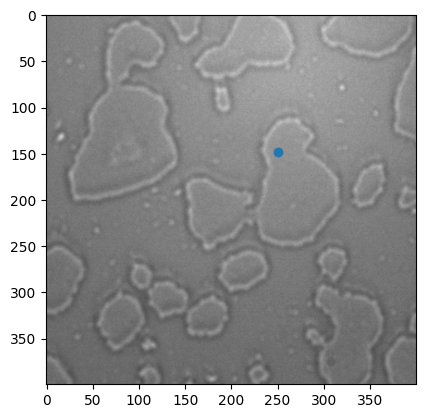

In [60]:
plt.figure()

plt.imshow(x, vmin=0, vmax=255, cmap='gray')
plt.scatter(*y)

plt.show()

In [ ]:
for x, y in dataloader_test:
    x = x.to(DEVICE)
    y = y.to(DEVICE)
    break

In [ ]:
model.eval()
y_pred = model(x)

In [ ]:
for i in range(len(y)):
    print( y[i].cpu().numpy(), y_pred[i].detach().cpu().numpy() )

In [ ]:
y_train_pred = model(x_train)

In [ ]:
for idx in x_train.shape[0]:
    img = x_train[idx,0].detach().cpu().numpy()
    coords = y_train[idx].detach().cpu().numpy()
    coords_pred = y_train_pred[idx].detach().cpu().numpy()


    plt.figure()
    plt.title(str(idx))
    plt.imshow(img, vmin=0, vmax=255, cmap='gray')
    plt.scatter(*(coords))
    plt.scatter(*(coords_pred), color='red')
    plt.show()